# LSTM optimizer 少量資料影像分類

在Optimization based meta learning 中，有一派做法是使用神經網路模型，訓練一個像是SGD,Adam 那樣的model optimizer。

在一個任務中，梯度下降是在每筆資料輸入、計算梯度後將model$\Phi$從$\Phi_0$往gradient的反方向$g_1$更新成$\Phi_1$。

這個過程在使用SGD來做就是$\theta_t=\theta_{t-1}+\lambda*gradient(\Phi_{t-1},data_t)$

可以把它濃縮成一個function: $\Phi_t=f(\Phi_{t-1},data_t)$

現在來看看RNN的使用公式: $h_t=activation(w^T [h_{t-1},data_t]+bias)$

也是可以把它濃縮成一個function: $h_t=f'(h_{t-1},data_t)$是不是跟前面什麼東西很像呢?

因此可以使用RNN這個模型類型來學習如何做model optimization，來優化訓練這件事，使得使用較少的資料就能達到訓練效果。

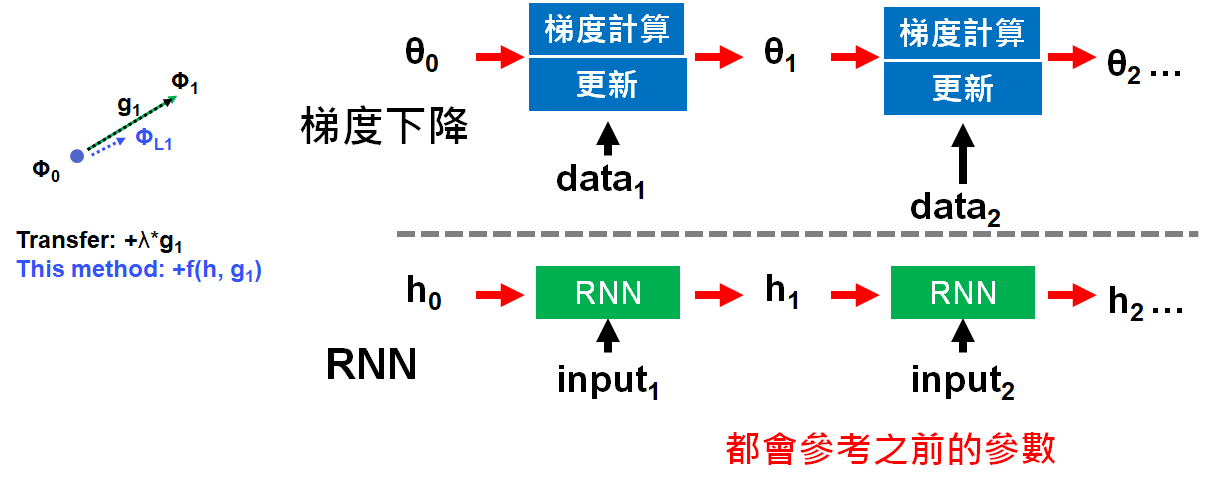

這次要訓練一個LSTM optimizer應用在學習MNIST影像分類上，其中包含以下部分：
* Data Loader
* 建立模型(CNN and LSTM)
* 訓練及驗證
* 細節說明

# Data Loader

In [1]:
# using tf 2.0
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import utils
import tqdm 
import itertools
from sklearn.model_selection import train_test_split
# Import hand craft scripts
import def_model
import data_gen

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth( device=gpu, enable=True)

首先讀取存好的MNIST資料分成訓練集、驗證集、測試集

In [2]:
DATA_DIR="./"
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data(path=DATA_DIR+"/MNIST/mnist.npz")
# data=np.load(DATA_DIR+"/MNIST/mnist.npz")
# x_train,y_train,x_test,y_test=[data[cont] for cont in ['x_train',"y_train","x_test","y_test"]]
x_train,x_val,y_train,y_val=train_test_split(x_train, y_train, test_size=len(y_train)//10*2)

使用Data Generator來Load資料進Model

In [3]:
way =10
MAX_EPOCHS = 40
BATCH_SIZE=128
gen_train=data_gen.DataGenerator(x_train,y_train,way,batch_size=BATCH_SIZE,shuffle=True)
gen_val=data_gen.DataGenerator(x_val,y_val,way,batch_size=BATCH_SIZE,shuffle=False)
len(gen_train), len(gen_val)

(375, 93)

看一下，資料內容如下：

資料內容包含圖片和數字，數字做過one-hot encoding

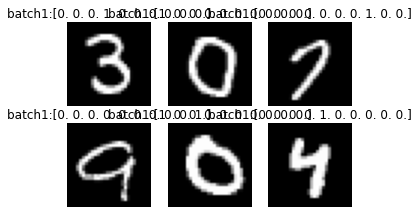

In [4]:
for batch_data,batch_label in gen_train:
    break
gp,ee,n_row,n_col=1,1,2,3
plt.figure(figsize=(n_col*1.7,n_row*1.7))
for ii in range(n_row):
    for jj in range(n_col):
        plt.subplot(n_row,n_col,ee);plt.axis('off');plt.title(f"batch{gp}:{batch_label[ee]}")
        plt.imshow(batch_data[ee,...,0],"gray")
        ee+=1
plt.show()

# 建立模型(CNN and LSTM)
目前我們要訓練的對象是一個CNN模型，使用的optimizer是一個LSTM。

整個Method如下：
1. 資料$data_t$進入CNN，以現在的CNN參數$\theta_{t-1}$計算答案、對照答案、計算梯度
2. 將梯度傳給RNN做input，與Hidden值$h_0$做concatenate，計算下一個hidden值$h_1$，並輸出給CNN的更新值
3. CNN apply RNN output做更新，參數變成$\theta_t$
4. 繼續做下一筆資料，重複1.~3.值到做完一個batch後對RNN做梯度更新
5. 一路訓練，直到CNN對data的loss不再下降

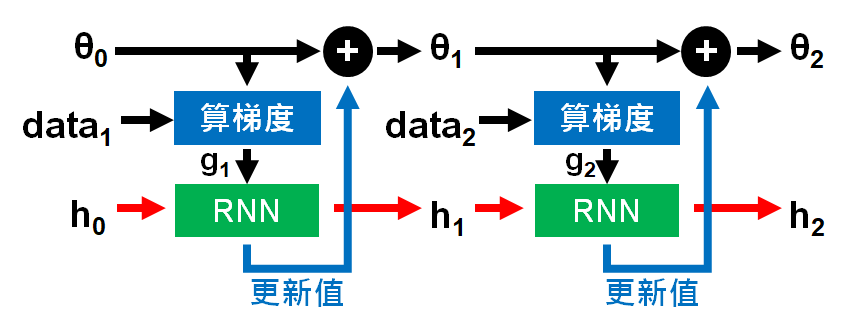

以下先建立CNN model還有一個LSTM model。

這邊使用客制化layer來做，不然不能將CNN model update當作forward的一環(gradient傳不回)。

詳見檔案: def_model.py

In [5]:
N_FILTER=32
CHS=32
cnn=def_model.cnn_model(way,N_FILTER)
lstm=def_model.LSTM_model(CHS)

看一下模型，我們這邊使用Xavior initialization，可以看到weight value的amplitude逐層有變小

這邊因為跑LSTM update會很慢，所以有稍微調整模型架構，使用1x1 conv來降低參數使用量。

最後大概參數是11k個

layer 0: w:(3, 3, 1, 32) + b: (32,) = 320
layer 1: w:(1, 1, 32, 16) + b: (16,) = 528
layer 2: w:(3, 3, 16, 32) + b: (32,) = 4640
layer 3: w:(1, 1, 32, 16) + b: (16,) = 528
layer 4: w:(3, 3, 16, 32) + b: (32,) = 4640
layer 5: w:(1, 1, 32, 16) + b: (16,) = 528
layer 6: w:(16, 10) + b: (10,) = 170
totla 11354 parameters


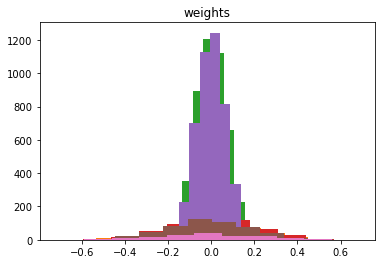

In [6]:
cnn.print_shape()
for ii in [cnn.cnn1,cnn.cnn1_1,cnn.cnn2,cnn.cnn2_1,cnn.cnn3,cnn.cnn3_1,cnn.dense]:
    plt.hist(np.reshape(ii.w.numpy(),-1))
plt.title("weights")
plt.show()

接下定義optimizer for RNN (RNN還是要有pre-defined optimizer去更新的)

並且這邊也先定義使用categorical cross entropy當loss，以及定義計算accuracy的function。

In [9]:
lr=0.01

opt_lstm=keras.optimizers.Adam(lr=lr)
cnn_loss_fn=keras.losses.categorical_crossentropy
acc_fn = keras.metrics.categorical_accuracy

### 將RNN狀態初始化

定義一個特別的參數將cnn的weight全部照順序壓成一維向量，好丟進LSTM。

另外rnn的state也需要初始化，丟給他一個全是1的initial state

In [10]:
def flat_tensors(mdl):
    tensors=tf.concat([tf.reshape(ww,[-1]) for ww in mdl],axis=0)
    return tf.reshape(tensors,(len(tensors),1,1))

cnn_param_num=sum([np.prod(ww.shape) for ww in cnn.trainable_weights()])
best_loss=np.Inf
flt_grads=flat_tensors(cnn.trainable_weights()).numpy().copy()
h=[[tf.ones((cnn_param_num,CHS)),tf.ones((cnn_param_num,CHS))],[tf.ones((cnn_param_num,CHS)),tf.ones((cnn_param_num,CHS))]]

自己組件的model沒有compiler,所以跑一次data同時compile

In [11]:
new_update,new_state=lstm.forward(flt_grads,state=h)

# 模型訓練與驗證
依照上述方式開始訓練模型並驗證

In [12]:
# flt_grads=tf.Variable(flat_tensors(cnn.trainable_weights()))
# h=[[tf.ones((cnn_param_num,CHS)),tf.ones((cnn_param_num,CHS))],[tf.ones((cnn_param_num,CHS)),tf.ones((cnn_param_num,CHS))]]

best_loss=np.Inf

for epoch in range(MAX_EPOCHS):
    train_sess=tqdm.tqdm(gen_train)
    train_acc=[]    
    '''每個batch的訓練'''
    for data,label_1_hot in train_sess:
        '''紀錄gradient'''
        # 記得要開persistant, 因為會有兩次的tape.gradient，如果不開只能用一次
        with tf.GradientTape(persistent=True) as tape:
            '''將上一個batch的gradient丟進LSTM，產出更新參數'''
            new_update,new_state=lstm.forward(flt_grads,state=h)
            new_update=tf.expand_dims(new_update,-1)
            
            '''將更新參數丟給cnn做update'''
            cnn.assign_update(new_update*0.01)
            
            '''使用cnn預測資料、計算loss'''
            logits=cnn(data)
            loss_cnn=cnn_loss_fn(tf.Variable(label_1_hot), logits)+tf.sqrt(tf.reduce_mean(new_update**2))*0.1
        '''計算loss造成cnn的gradient'''
        grads_cnn=tape.gradient(loss_cnn,cnn.trainable_weights())
        
        '''計算CNN的gradient造成lstm的gradient，也記錄這次LSTM的state以及CNN的gradient，供下個batch使用'''
        grads=tape.gradient(new_update,lstm.trainable_weights,output_gradients=-flat_tensors(grads_cnn))
        h=new_state
        flt_grads=flat_tensors(grads_cnn)
        
        '''對LSTM進行更新，並記錄訓練效果'''
        opt_lstm.apply_gradients(zip(grads, lstm.trainable_weights))
        acc=acc_fn(label_1_hot,logits).numpy().mean()
        train_acc.append(acc)
        train_sess.set_postfix({"CNN loss": loss_cnn.numpy().mean(),"acc":np.mean(train_acc)})
    
    '''每個batch的驗證'''
    val_acc=[]
    val_loss=[]
    for data,label_1_hot in gen_val:
        '''將資料丟入CNN，算loss'''
        logits=cnn(data)
        loss_cnn=cnn_loss_fn(label_1_hot, logits).numpy()
        
        '''記錄驗證資料'''
        acc=acc_fn(label_1_hot,logits).numpy().mean()
        val_loss.append(loss_cnn)
        val_acc.append(acc)
    print(f"CNN val: loss: {np.mean(val_loss):.08f},acc: {np.mean(val_acc):.02f},lr: {lr}")
    
    '''Early Stop'''
    if best_loss<np.mean(val_loss):
        print("Early Stop")
        break
    else:
        best_loss=np.mean(val_loss)


  1%|          | 2/375 [00:00<00:25, 14.80it/s, CNN loss=0.511, acc=0.898]

CNN val: loss: 0.34049982,acc: 0.90,lr: 0.01


  0%|          | 1/375 [00:00<00:38,  9.70it/s, CNN loss=0.223, acc=0.917]

CNN val: loss: 0.29762515,acc: 0.91,lr: 0.01


  1%|          | 2/375 [00:00<00:24, 15.02it/s, CNN loss=0.24, acc=0.914] 

CNN val: loss: 0.28979611,acc: 0.91,lr: 0.01


  1%|          | 2/375 [00:00<00:24, 15.08it/s, CNN loss=0.29, acc=0.911] 

CNN val: loss: 0.26157227,acc: 0.92,lr: 0.01


  1%|          | 2/375 [00:00<00:24, 15.14it/s, CNN loss=0.257, acc=0.917]

CNN val: loss: 0.24039154,acc: 0.93,lr: 0.01


  0%|          | 1/375 [00:00<00:38,  9.67it/s, CNN loss=0.172, acc=0.938]

CNN val: loss: 0.23573722,acc: 0.93,lr: 0.01


  0%|          | 1/375 [00:00<00:38,  9.64it/s, CNN loss=0.166, acc=0.938]

CNN val: loss: 0.22117689,acc: 0.93,lr: 0.01


100%|██████████| 375/375 [00:16<00:00, 22.76it/s, CNN loss=0.344, acc=0.934] 


CNN val: loss: 0.29274780,acc: 0.92,lr: 0.01


# 細節說明

1. 把flt_grad也就是攤成1維的gradient 資料拿起來看，會像下面這樣，他也就是一個tf.Variable，可供我們操作

In [12]:
flt_grads

<tf.Variable 'Variable:0' shape=(11354, 1, 1) dtype=float32, numpy=
array([[[0.10415524]],

       [[0.05907608]],

       [[0.00555555]],

       ...,

       [[0.        ]],

       [[0.        ]],

       [[0.        ]]], dtype=float32)>

2. 中間CNN更新部分如下，要用assign_sub來對參數做減法，SGD是減去$\lambda* gradient$，在這個LSTM optimizer是減去LSTM輸出值

In [13]:
def assign_update(tensors,model):
    nn=0
    for ww in [model.cnn1,model.cnn1_1,model.cnn2,model.cnn2_1,model.cnn3,model.cnn3_1,model.dense]:
        flt_len=np.prod(ww.w.shape)
        ww.w.assign_sub(tf.reshape(tensors[nn:nn+flt_len],ww.w.shape))
        nn+=flt_len

        flt_len=np.prod(ww.b.shape)
        ww.b.assign_sub(tf.reshape(tensors[nn:nn+flt_len],ww.b.shape))
        nn+=flt_len

可以看見，這個LSTM輸出的new_update 的rank跟上面flt_grads不一樣，所以剛剛有做調整

In [26]:
new_update

<tf.Tensor: id=1425, shape=(11354, 1), dtype=float32, numpy=
array([[-0.48308235],
       [-0.4829991 ],
       [-0.48282486],
       ...,
       [-0.48278546],
       [-0.48278546],
       [-0.48278546]], dtype=float32)>

3. 這個專案其中一件作業是要將loss對CNN造成的gradient傳回LSTM的output讓LSTM能夠算gradient，但cnn weight的變化造成的gradient不能直接back propagate給lstm

In [13]:
nn=0
with tf.GradientTape() as tape:
    new_update,new_state=lstm.forward(flt_grads,state=h)
    new_update=tf.Variable(new_update)
    nn=0
    for ww in [cnn.cnn1,cnn.cnn1_1,cnn.cnn2,cnn.cnn2_1,cnn.cnn3,cnn.cnn3_1,cnn.dense]:
        flt_len=np.prod(ww.w.shape)
        ww.w=ww.w.assign_sub(tf.reshape(new_update[nn:nn+flt_len],ww.w.shape))
        nn+=flt_len

        flt_len=np.prod(ww.b.shape)
        ww.b=ww.b.assign_sub(tf.reshape(new_update[nn:nn+flt_len],ww.b.shape))
        nn+=flt_len
        
grad=tape.gradient(cnn.cnn1.w,lstm.trainable_weights)

In [14]:
grad

[None, None, None, None, None, None]

可以看到，這樣將gradient更新值直接用做lstm的loss，會算不出gradient

In [15]:
 with tf.GradientTape() as tape:
    new_update,new_state=lstm.forward(flt_grads,state=h)
    cnn.assign_update(new_update)
    logits=cnn(data)
    loss1=cnn_loss_fn(label_1_hot, logits)
grads=tape.gradient(loss1,lstm.trainable_weights)

In [16]:
grads

[None, None, None, None, None, None]

若直接以cnn的loss去回傳給lstm算gradient更是算不出來

最後使用上面用的persistent=True加上output_gradients的方式做back propagation

# Reference
* [Andrychowicz, M., Denil, M., Gomez, S., Hoffman, M. W., Pfau, D., Schaul, T., ... & De Freitas, N. (2016). Learning to learn by gradient descent by gradient descent. arXiv preprint arXiv:1606.04474.](https://arxiv.org/abs/1606.04474)
* 
(官方網站的code連結是誤值，目前無其他github網頁做python的版本)